In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import pickle as pkl
import random

random.seed(42)
np.random.seed(42)

In [2]:
# mean1 = [1,1]
# cov1 = [[1,0],[0,1]]
# mean2 = [4,4]
# cov2 = [[1,0],[0,1]]


# random.seed(35)
# np.random.seed(35)
# data1 = np.random.multivariate_normal(mean1, cov1, 60000)
# y1 = np.zeros(60000)
# data2 = np.random.multivariate_normal(mean2, cov2, 140000)
# y2 = np.ones(140000)
# X =np.vstack((data1,data2))
# y =np.hstack((y1,y2))
# with open('q1_sec.pickle', 'wb') as handle:
#     pkl.dump([X,y], handle, protocol=pkl.HIGHEST_PROTOCOL)

In [3]:
with open('q1.pickle', 'rb') as handle:
    b = pkl.load(handle)
    X,y=b
    X=np.array(X)
    y=np.array(y)

X0=np.array([list(X[i]) for i in range(len(y)) if y[i]==0])
X1=np.array([list(X[i]) for i in range(len(y)) if y[i]==1])

prior0=len(X0)/len(X)
prior1=len(X1)/len(X)

prior0,prior1

(0.3, 0.7)

In [4]:
def calculate_cov(X):
    X=np.array(X)
    N, M = X.shape
    # Calculate the covariance matrix
    cov = np.zeros((M, M))
    for i in range(M):
        # Mean of column "i"
        mean_i = np.sum(X[:, i]) / N
        for j in range(M):
            # Mean of column "j"
            mean_j = np.sum(X[:, j]) / N
            # Covariance between column "i" and column "j"
            cov[i, j] = np.sum((X[:, i] - mean_i) * (X[:, j] - mean_j)) / (N-1)
    return cov

cov=calculate_cov(X1)
cov,np.cov(X1,rowvar=False)

(array([[1.00181041, 0.00409282],
        [0.00409282, 0.99503845]]),
 array([[1.00181041, 0.00409282],
        [0.00409282, 0.99503845]]))

In [5]:
def max_likelihood(X):
    mean=np.mean(X,axis=0)
#     conv=np.cov(X,rowvar=False)
    cov=calculate_cov(X)
    return mean,cov


mean0,cov0=max_likelihood(X0)
mean1,cov1=max_likelihood(X1)


mus=np.array([mean0,mean1])
sigmas=np.array([cov0,cov1])
priors=np.array([prior0,prior1])
print(f"{mus}\n\n,{sigmas}\n\n,{priors},\n\n{X[100]}")

[[1.00085009 1.0038003 ]
 [3.99905894 4.00033036]]

,[[[ 1.00643946 -0.00193469]
  [-0.00193469  0.9966508 ]]

 [[ 1.00181041  0.00409282]
  [ 0.00409282  0.99503845]]]

,[0.3 0.7],

[-0.26141452  1.98797281]


In [6]:
class multi_case_1():
    def __init__ (self,mus,sigmas,priors):
        self.mus=mus
        self.sigmas=sigmas
        self.priors=priors
        values=self.calculate_case_1()
        print(f"Paramter Values calculated: ", values)
        return None
    
    def calculate_case_1(self):
        mu_diff=(self.mus[0]-self.mus[1])
        self.w= mu_diff
        self.x0= 1/2 * (self.mus[0]+self.mus[1]) - (self.sigmas[0][0]**2)/((np.linalg.norm(mu_diff))**2)*(math.log(priors[0]/priors[1])*mu_diff)
        return self.w,self.x0
    
    def decision_boundry_fn(self,x):
        return np.matmul(self.w.T, (x-self.x0))
    
    def predict(self,X):
        op_data=[np.matmul(self.w.T, (x-self.x0)) for x in X]
        to_ret=[0 if x>0 else 1 for x in op_data]
        return np.array(to_ret)

In [7]:
model1=multi_case_1(mus,sigmas,priors)

Paramter Values calculated:  (array([-2.99820885, -2.99653006]), array([2.35674802, 2.5020648 ]))


In [8]:
sigma_inv=np.linalg.inv(sigmas[0])
mu_diff=mus[0]-mus[1]


In [9]:
class multi_case_2():
    def __init__ (self,mus,sigmas,priors):
        self.mus=mus
        self.sigmas=sigmas
        self.priors=priors
        values=self.calculate_case_2()
        print(f"Paramter Values calculated: ", values)
        return None
    
    def calculate_case_2(self):
        sigma_inv=np.linalg.inv(self.sigmas[0])
        mu_diff=self.mus[0]-self.mus[1]
        self.w=np.dot(sigma_inv,mu_diff)
        self.x0=((self.mus[0]+self.mus[1])/2)-np.log(self.priors[0]/priors[1])*mu_diff/(np.matmul(np.matmul(mu_diff.T,sigma_inv),mu_diff))
        return self.w,self.x0
    
    def decision_boundry_fn(self,x):
        return np.matmul(self.w.T, (x-self.x0))
    
    def predict(self,X):
        op_data=[np.matmul(self.w.T, (x-self.x0)) for x in X]
        to_ret=[0 if x>0 else 1 for x in op_data]
        return np.array(to_ret)

In [10]:
model2=multi_case_2(mus,sigmas,priors)

Paramter Values calculated:  (array([-2.98481629, -3.01239386]), array([2.35863277, 2.36082271]))


In [11]:
class multi_case_3():
    def __init__ (self,mus,sigmas,priors):
        self.mus=mus
        self.sigmas=sigmas
        self.priors=priors
        values=self.calculate_case_3_constants()
        print(f"Paramter Values calculated: {self.W12}\n{self.W22}\n{self.w11}\n{self.w21}\n{self.w10}\n{self.w20}")
        
        return None
    
    def calculate_case_3_constants(self):
        dimension=len(self.mus[0])
        print(self.sigmas.shape)
        if (dimension,dimension) != self.sigmas[0].shape:
            return NameError("Dimension mismatch")
        mu1=self.mus[0]
        mu2=self.mus[1]
        sigma1=self.sigmas[0]
        sigma2=self.sigmas[1]
        sigma1_inv=np.linalg.inv(sigma1)
        sigma2_inv=np.linalg.inv(sigma2)
        prior1=self.priors[0]
        prior2=self.priors[1]
        self.W12=-1/2*sigma1_inv
        self.W22=-1/2*sigma2_inv
        self.w11=np.matmul(sigma1_inv,mu1)
        self.w21=np.matmul(sigma2_inv,mu2)
        self.w10=-1/2*np.matmul(np.matmul(mu1.T,sigma1_inv),mu1) - 1/2*np.log(np.linalg.det(sigma1)) + np.log(priors[0])
        self.w20=-1/2*np.matmul(np.matmul(mu2.T,sigma2_inv),mu2) - 1/2*np.log(np.linalg.det(sigma2)) + np.log(priors[1])
        return self.W12,self.W22,self.w11,self.w21,self.w10,self.w20
    
    def decision_boundry_fn(self,x):
        return np.matmul(np.matmul(x.T,(self.W12-self.W22)), x) + np.matmul((self.w11.T-self.w21.T),x) + (self.w10-self.w20) 
    
    def predict(self,X):
        op_data=[np.matmul(np.matmul(x.T,(self.W12-self.W22)), x) + np.matmul((self.w11.T-self.w21.T),x) + (self.w10-self.w20) for x in X]
        to_ret=[0 if x>0 else 1 for x in op_data]
        return np.array(to_ret)
        

In [12]:
model3=multi_case_3(mus,sigmas,priors)

(2, 2, 2)
Paramter Values calculated: [[-0.49680272 -0.00096439]
 [-0.00096439 -0.5016821 ]]
[[-0.49910482  0.00205293]
 [ 0.00205293 -0.50250159]]
[0.99638621 1.0091077 ]
[3.97547436 4.00392514]
-2.210590850238254
-16.312673762563197


In [13]:
y_true=y
y_pred=model3.predict(X)
print(y_pred.shape)

def misclf_rate(y_true, y_pred):
    y_true=list(y_true)
    y_pred=list(y_pred)
    total_class1 = y_true.count(0)
    total_class2 = y_true.count(1)
    misclf_class1 = 0
    misclf_class2 = 0    
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()    
    total_misclassification_rate = (fp+fn)/(tn+fp+fn+tp)   
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            if y_true[i] == 0:
                misclf_class1 += 1
            elif y_true[i] == 1:
                misclf_class2 += 1   
            
    class1_misclf_rate = misclf_class1/total_class1
    class2_misclf_rate = misclf_class2/total_class2
    full_misclassi=(misclf_class1+misclf_class2)/len(y_true)
    if full_misclassi==total_misclassification_rate:
        print("misclassification is fine")
    return class1_misclf_rate,class2_misclf_rate,total_misclassification_rate

c1_mis,c2_mis,tot_mis=misclf_rate(y_true,y_pred)
c1_mis,c2_mis,tot_mis

(200000,)
misclassification is fine


(0.02725, 0.0104, 0.015455)

In [18]:
def error_rate_for(percentage=0.01,X=X,y=y):
    np.random.seed(35)
    
    train_i=np.random.choice(range(len(X)),int(len(X)*0.01*percentage),replace=False)
    train_X=[X[i] for i in train_i]
    train_y=[y[i] for i in train_i]
    X0=np.array([list(train_X[i]) for i in range(len(train_y)) if train_y[i]==0])
    X1=np.array([list(train_X[i]) for i in range(len(train_y)) if train_y[i]==1])

    
#     X0_=np.array([list(X[i]) for i in range(len(y)) if y[i]==0])
#     X1_=np.array([list(X[i]) for i in range(len(y)) if y[i]==1])
#     print(int(len(X0_)*0.01*percentage),int(len(X1_)*0.01*percentage))
    
#     train_i0=np.random.choice(range(len(X0_)),int(len(X0_)*0.01*percentage),replace=False)
#     train_i1=np.random.choice(range(len(X1_)),int(len(X1_)*0.01*percentage),replace=False)
#     X0=[X0_[i] for i in train_i0]
#     X1=[X1_[i] for i in train_i1]
# #     train_X0,train_X1

#     plt.plot(X0[:, 0], X0[:, 1], '.', alpha=0.5, markersize=1)
#     plt.plot(X1[:, 0], X1[:, 1], '.', alpha=0.5, markersize=1)
#     plt.axis('equal')
#     plt.grid()
#     plt.show()
    
    prior0=len(X0)/(len(X0)+len(X1))
    prior1=len(X1)/(len(X0)+len(X1))
    
    mean0,cov0=max_likelihood(X0)
    mean1,cov1=max_likelihood(X1)
    
#     cov0=[[cov0[0][0],0],[0,cov0[1][1]]]
#     cov1=[[cov1[0][0],0],[0,cov1[1][1]]]

    mean0=[1,1]
    mean1=[4,4]
    cov0=[[1,0],[0,1]]
    cov1=[[1,0],[0,1]]

    mus=np.array([mean0,mean1])
    sigmas=np.array([cov0,cov1])
    priors=np.array([prior0,prior1])
    print(f"mus={mus}\n\n,sigmas={sigmas}\n\n,priors={priors}")
    
#     if np.array_equal(cov0,cov1):
#         if cov0[0][0]==cov0[1][1] and cov0[0][1]==0 and cov0[1][0]==0:
#             model=multi_case_1(mus,sigmas,priors)
#         else:
#             model=multi_case_2(mus,sigmas,priors)
#     else:
    model=multi_case_3(mus,sigmas,priors)
        
    y_pred=model.predict(X)
    print("prediction_shape vs y_true shape:",y_pred.shape, "   ", y.shape)
    
    c1_mis,c2_mis,tot_mis=misclf_rate(y_true=y,y_pred=y_pred)
    
    return c1_mis,c2_mis,tot_mis,model

In [19]:
c1_mis,c2_mis,tot_mis,model_f=error_rate_for(percentage=100,X=X,y=y)

c1_mis,c2_mis,tot_mis

mus=[[1 1]
 [4 4]]

,sigmas=[[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

,priors=[0.3 0.7]
(2, 2, 2)
Paramter Values calculated: [[-0.5 -0. ]
 [-0.  -0.5]]
[[-0.5 -0. ]
 [-0.  -0.5]]
[1. 1.]
[4. 4.]
-2.203972804325936
-16.35667494393873
prediction_shape vs y_true shape: (200000,)     (200000,)
misclassification is fine


(0.0272, 0.010435714285714286, 0.015465)

In [16]:
(0.021333333333333333, 0.013707142857142857, 0.015995)

(0.021333333333333333, 0.013707142857142857, 0.015995)

shape of x_in, (1000000, 2)
doing binary classifcation...


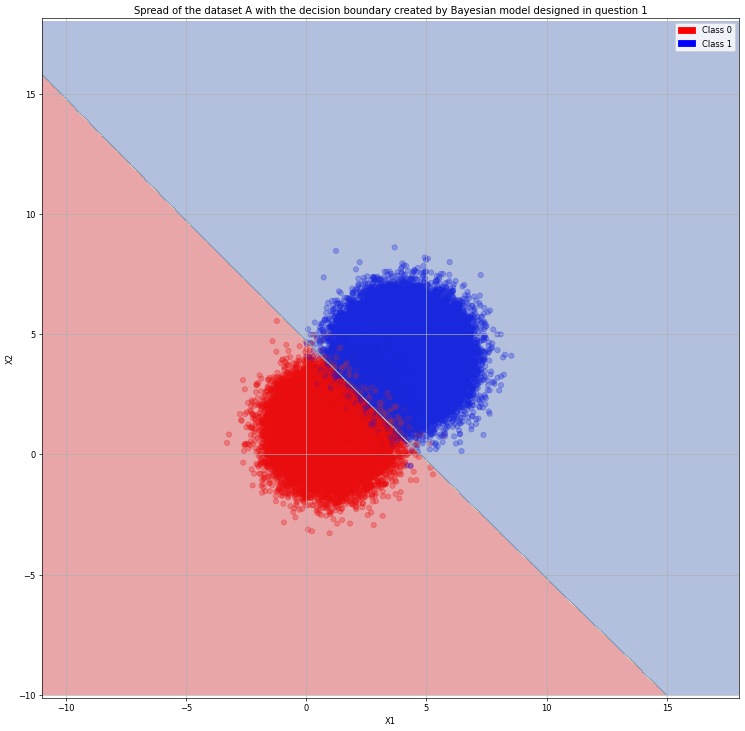

In [17]:
def plot_decision_boundary(model, X, y):
    # Define the axis boundaries of the plot and create a meshgrid
    
    x_min, x_max = -11,18
    y_min, y_max = -10,18
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] 
    
    # Make predictions using the trained model
    print(f"shape of x_in, {x_in.shape}")
    y_pred = model.predict(x_in)
    y_pred=[[x] for x in y_pred]
    # Check for multi-class
    if len(y_pred[0]) > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(y_pred).reshape(xx.shape)
        
    # Plot decision boundary
    plt.figure(figsize=(15,15), dpi=60)
    p=np.concatenate((X.T,np.array([y])),axis=0).T
    np.random.shuffle(p)
    color= ['red' if l == 0 else 'blue' for l in p[:,2]]
    plt.scatter(p[:, 0], p[:, 1], s=40, color=color, alpha=0.3)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.4)
#     plt.scatter([1],[1], s=20, color=["green"], alpha=1)
#     plt.scatter([4],[4], s=20, color=["yellow"], alpha=1)
    plt.axis('equal')
    plt.title("Spread of the dataset A with the decision boundary created by Bayesian model designed in question 1")
    plt.xlabel("X1")
    plt.ylabel("X2")
    red_patch = mpatches.Patch(color='red', label='Class 0')
    blue_patch = mpatches.Patch(color='blue', label='Class 1')
    plt.legend(handles=[red_patch, blue_patch])
    plt.grid()
    
plot_decision_boundary(model_f,X,y)